In [1]:
# !wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null
# !tar xvzf ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null

# import os

# os.chdir('ta-lib') # Can't use !cd in co-lab

# !./configure --prefix=/usr 2>&1 > /dev/null
# !make 2>&1 > /dev/null
# !make install 2>&1 > /dev/null

# os.chdir('../')

# !pip install TA-Lib 2>&1 > /dev/null

In [2]:
# !pip install yfinance

In [436]:
from pandas.core.frame import DataFrame
import yfinance as yf
import numpy as np
import talib as ta
import pandas as pd

In [437]:
def get_score(df: DataFrame, indicator: str, entry_type='long'):
	indicator = indicator.upper()
 
	if indicator == 'RSI' and entry_type == 'long':
		try:
			rsiValue = df.rsi.head(1).values[0]
			if rsiValue in range(60,70):
				return 5
			elif rsiValue in range(70,80):
				return 4
			elif rsiValue >= 80:
				return 3
			elif rsiValue in range(50,60):
				return 2
			else:
				return 0
		except IndexError:
			return 0
	if indicator == 'MACD' and entry_type == 'long':
		macd = df.macd_crossover
		try:
			date = macd.iloc[list(np.where(df["macd_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA' and entry_type == 'long':
		try:
			date = df.ema_crossover.iloc[list(np.where(df["ema_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'VOLUME' and entry_type == 'long':
		try:
			date = df.volume_buy.iloc[list(np.where(df["volume_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	return None

In [438]:
data = pd.read_csv('INFY.csv')
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-21,963.049988,963.450012,946.549988,948.799988,928.694214,6513773
2020-08-24,947.000000,952.000000,939.200012,947.400024,927.323975,5798574
2020-08-25,947.500000,948.650024,933.599976,938.099976,918.220947,6233918
2020-08-26,941.250000,954.250000,938.400024,950.799988,930.651855,5153601
2020-08-27,960.000000,960.950012,945.200012,947.049988,926.981323,6154280


In [439]:
span = 4

In [440]:
data = data.tail(span+5)

In [441]:
#data = DataFrame(yf.download('BTC-USD','2016-01-01',current_date))

In [442]:
data = data.drop(['Adj Close'], axis = 1)

In [443]:
data['5EMA'] = pd.Series.ewm(data['Close'], span=5).mean()

data['26EMA'] = pd.Series.ewm(data['Close'], span=26).mean()

data['rsi'] = ta.RSI(data['Close'].values, timeperiod=14)

data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(data.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)

data['macd_crossover'] = np.where(((data.macd > data.macdSignal) & (data.macd.shift(1) < data.macdSignal.shift(1))), 1, 0)
data['macd_crossunder'] = np.where(((data.macd < data.macdSignal) & (data.macd.shift(1) > data.macdSignal.shift(1))), 1, 0)
data['ema_crossover'] = np.where(((data['5EMA'].shift(1) <= data['26EMA'].shift(1)) & (data['5EMA'] > data['26EMA'] )), 1, 0)
data['ema_crossunder'] = np.where(((data['5EMA'].shift(1) >= data['26EMA'].shift(1)) & (data['5EMA'] < data['26EMA'] )), 1, 0)

data['rsi_buy'] = np.where(data.rsi > 60, 1, 0)
data['rsi_sell'] = np.where(data.rsi < 40, 1, 0)

data['volume_buy'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close > data.Close.shift(1)), 1, 0)
data['volume_sell'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close < data.Close.shift(1)), 1, 0)

last_week_data = data.tail(5).sort_values(by='Date', ascending=False)
rsiScore = get_score(last_week_data, indicator='rsi')
macdScore = get_score(last_week_data, indicator='macd')
emaScore = get_score(last_week_data, indicator='ema')
volumeScore = get_score(last_week_data, indicator='volume')
totalScore = rsiScore + macdScore + emaScore + volumeScore

/tmp/ipykernel_3063/3700509915.py:48: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:


In [444]:
totalScoreL = [0,0,0,0,0]
for i in range(len(data.index.values)-5):
	df = data[i:i+5]
	rsiScore = get_score(df, indicator='rsi')
	macdScore = get_score(df, indicator='macd')
	emaScore = get_score(df, indicator='ema')
	volumeScore = get_score(df, indicator='volume')
	totalScore = rsiScore + macdScore + emaScore + volumeScore
	totalScoreL.append(totalScore)
len(totalScoreL)

/tmp/ipykernel_3063/3700509915.py:37: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:
/tmp/ipykernel_3063/3700509915.py:48: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:


9

In [445]:
print(len(data))
data

9


,Open,High,Low,Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,macdHist,macd_crossover,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell
Date,,,,,,,,,,,,,,,,,,,
2021-08-06,1657.000000,1660.650024,1644.000000,1650.199951,3754855,1650.199951,1650.199951,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-09,1661.000000,1667.449951,1646.400024,1663.300049,5018477,1658.060010,1657.001925,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,0
2021-08-10,1668.000000,1680.000000,1661.050049,1677.250000,6846517,1667.150005,1664.276862,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-11,1674.800049,1684.000000,1668.000000,1677.550049,4899639,1671.470023,1667.987465,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-12,1679.150024,1696.500000,1674.000000,1689.599976,5659579,1678.429863,1672.999495,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1


In [446]:
data = data.iloc[5:,:]

In [447]:
data['totalScore'] = totalScoreL[5:]
data['totalScore last'] = data.totalScore.ewm(span=span).mean()

/tmp/ipykernel_3063/2006868685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['totalScore'] = totalScoreL[5:]
/tmp/ipykernel_3063/2006868685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['totalScore last'] = data.totalScore.ewm(span=span).mean()


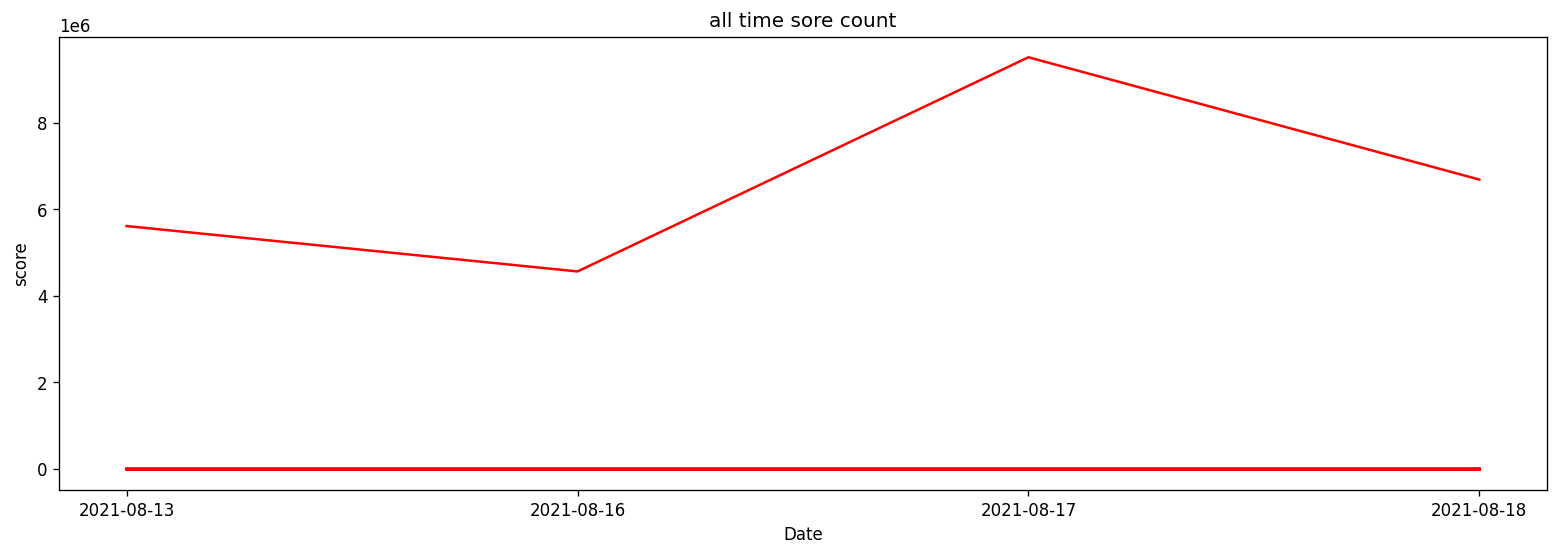

In [448]:
import matplotlib.pyplot as plt
def draw_ts_plot(timeseries, xlabel ='Date', ylabel ='totalScore', title ="", dpi=120):
    plt.figure(figsize=(16,5),dpi=dpi)
    plt.plot(timeseries, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

draw_ts_plot(data, xlabel="Date", ylabel = "score", title="all time sore count")

In [449]:
len(data)

4

In [450]:
data

,Open,High,Low,Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,...,macd_crossover,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScore last
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,8,8.000000
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,10,9.250000
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,5,7.081633
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,4,5.665441


In [451]:
data['dates'] = data.index.values
data['dates'] = data['dates'].apply(lambda x: x.split('-')[2])

/tmp/ipykernel_3063/1350104779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dates'] = data.index.values
/tmp/ipykernel_3063/1350104779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dates'] = data['dates'].apply(lambda x: x.split('-')[2])


In [452]:
totalScoreX = data.iloc[:,-2:-1]

In [453]:
datesY = data["dates"]
datesY = datesY.astype(int)

In [454]:
data

,Open,High,Low,Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,...,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScore last,dates
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,NaN,...,0,0,0,0,0,1,0,8,8.000000,13
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,NaN,...,0,0,0,0,0,0,0,10,9.250000,16
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,NaN,...,0,0,0,0,0,1,0,5,7.081633,17
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,NaN,...,0,0,0,0,0,0,1,4,5.665441,18


In [455]:
len(totalScoreX),len(datesY)

(4, 4)

In [456]:
data = data.iloc[:-1]

In [457]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(datesY).reshape(-1, 1), totalScoreX)

LinearRegression()

In [458]:
data.tail(10)

,Open,High,Low,Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,...,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScore last,dates
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,NaN,...,0,0,0,0,0,1,0,8,8.000000,13
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,NaN,...,0,0,0,0,0,0,0,10,9.250000,16
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,NaN,...,0,0,0,0,0,1,0,5,7.081633,17


/home/vivek/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


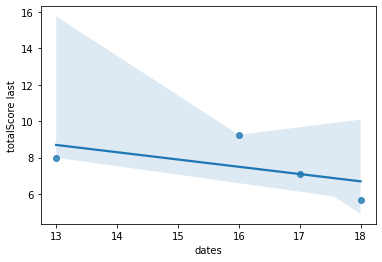

In [459]:
import seaborn as sns
sns.regplot(datesY, totalScoreX)
plt.show()

In [460]:
yhat = model.predict([[18]]) #predict score for next day
yhat

array([[6.70105632]])

In [461]:
data.iloc[:,-2:]

,totalScore last,dates
Date,,
2021-08-13,8.000000,13
2021-08-16,9.250000,16
2021-08-17,7.081633,17


In [462]:
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
# x =Open	High	Low	Close	Volume
# y = 5EMA	26EMA	rsi	macd	macdSignal	macdHist
regressor.fit(np.asarray(data['totalScore last']).reshape(-1, 1),data['Close'])

RandomForestRegressor(random_state=0)

/home/vivek/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


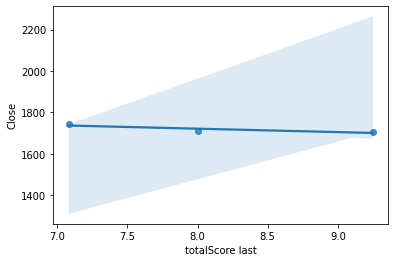

In [463]:
import seaborn as sns
sns.regplot(data['totalScore last'], data['Close'])
plt.show()

In [464]:
regressor.predict(yhat)#predict close

array([1731.15150757])